<p style="font-size:36px;text-align:center"> <b>Personalized cancer diagnosis</b> </p>

<img src="cancer.jpg" width="800" height="400">

### 1. Buisness Problem

Classify the given genetic variations/mutations based on evidence from text-based clinical literature.

### 1.1. Detailed Explaination :

    Once patient seems to have some problem, they take cancer tumor from person and then sequence the cancer tumor {i.e genetic sequence}
    So after doing genetic sequencing of cancer tumor we get (gene & gene variation) 
    A small change in gene can corrupt the entire genetic core system and can cause cancer.
    Note: ( Not all type of gene mutation does not cause cancer...)
    And based on what gene it is and what type of variation it is we can classify each patient into Categories (i.e. 9 classes)
    Gene , Varaiation ----->>> Category

### 1.2. Workflow :

     Step 1 : Lets take a domain expert who understand about gene mutation, selects list of [genetic varaiations]
    he want to analyize.
    Genetic variations divide into 2 parts (1: gene {on which variation is happening} 2: varaiation {exact varations})
    Both can be considered as [Random Categorical Variables]
    
    Step 2 : Domain Expert will now search/ collect all research papers/ evidence/ text that has been done on this
    gene variations
    
    Step 3 : Spend some time on analyzing Text [i.e. Evidence / Reseach work] amd after that Determine that patient
    belongs to which of the class out of (1,2,3,4....,9)

#### Special Thanks to: https://www.kaggle.com/c/msk-redefining-cancer-treatment/discussion/35336#198462

## 1.3. Objective and Constraints
      1: No Low-Latency requirement.
      2: Error can be very Costly
      3: Calculate Probablities on given data points to predict class label.

## 2. Data Overview 
### Source:  https://www.kaggle.com/c/msk-redefining-cancer-treatment/

- Both these data files are have a common column called ID
- <p> 
    Data file's information:
    <ul> 
        <li>
        training_variants (ID , Gene, Variations, Class)
        </li>
        <li>
        training_text (ID, Text)
        </li>
    </ul>
</p>

## 2.1 Mapping Real world Problem into ML problem

### 2.1.2. Type of ML Problem

<p>
    
    There are nine different classes a genetic mutation can be classified into => Multi class classification problem
   
      
    
</p>

### 2.1.3 Performance Metric

Metric(s): 
* Multi class log-loss 
* Confusion matrix 

## 3. Exploratory Data Analysis

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import re
import time
import warnings
warnings.filterwarnings("ignore")
import nltk
nltk.download('stopwords')
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import normalize
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

[nltk_data] Downloading package stopwords to C:\Users\Nihar
[nltk_data]     J\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 3.1 Loading Data

### 3.1.1 Load training_variants data

In [2]:
data = pd.read_csv('training/training_variants')  # Data 1
print('Number of data points : ', data.shape[0]) # number of rows
print('Number of features : ', data.shape[1])    # number of col
print('Features : ', data.columns.values)      # Features name
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


<ul>
        <li><b>ID : </b>the id of the row used to link the mutation to the clinical evidence</li>
        <li><b>Gene : </b>the gene where this genetic mutation is located </li>
        <li><b>Variation : </b>the aminoacid change for this mutations </li>
        <li><b>Class :</b> 1-9 the class this genetic mutation has been classified on</li>
    </ul>

### 3.1.2 Load training_text

In [3]:
data_text =pd.read_csv("training/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


## 4.1 Text Preprocessing

In [4]:
stop_words = stopwords.words('english')

In [5]:
def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [6]:
#text processing stage.
start_time = time.clock()
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 409.765932798 seconds


### 4.2 Merge Both datasets

In [7]:
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


### 4.2.1 Test, Train and Cross Validation Split (64:20:16)

In [8]:
y_true = result['Class'].values
result.Gene      = result.Gene.str.replace('\s+', '_')      #Multiple spaces to single
result.Variation = result.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [9]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


#### 4.2.2. Distribution of y_i's in Train, Test and Cross Validation datasets

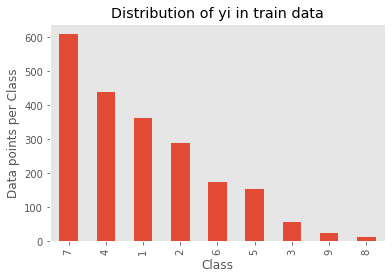

Number of data points in class 1 : 609 ( 28.672 %)
Number of data points in class 2 : 439 ( 20.669 %)
Number of data points in class 3 : 363 ( 17.09 %)
Number of data points in class 4 : 289 ( 13.606 %)
Number of data points in class 5 : 176 ( 8.286 %)
Number of data points in class 6 : 155 ( 7.298 %)
Number of data points in class 7 : 57 ( 2.684 %)
Number of data points in class 8 : 24 ( 1.13 %)
Number of data points in class 9 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


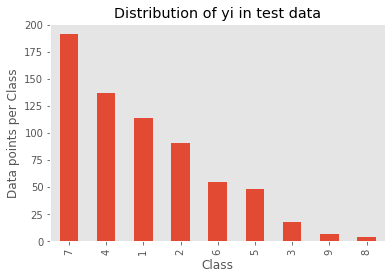

Number of data points in class 1 : 191 ( 28.722 %)
Number of data points in class 2 : 137 ( 20.602 %)
Number of data points in class 3 : 114 ( 17.143 %)
Number of data points in class 4 : 91 ( 13.684 %)
Number of data points in class 5 : 55 ( 8.271 %)
Number of data points in class 6 : 48 ( 7.218 %)
Number of data points in class 7 : 18 ( 2.707 %)
Number of data points in class 8 : 7 ( 1.053 %)
Number of data points in class 9 : 4 ( 0.602 %)
--------------------------------------------------------------------------------


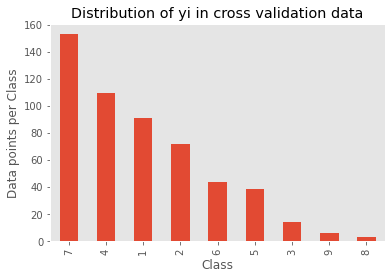

Number of data points in class 1 : 153 ( 28.759 %)
Number of data points in class 2 : 110 ( 20.677 %)
Number of data points in class 3 : 91 ( 17.105 %)
Number of data points in class 4 : 72 ( 13.534 %)
Number of data points in class 5 : 44 ( 8.271 %)
Number of data points in class 6 : 39 ( 7.331 %)
Number of data points in class 7 : 14 ( 2.632 %)
Number of data points in class 8 : 6 ( 1.128 %)
Number of data points in class 9 : 3 ( 0.564 %)


In [10]:
# it returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = train_df['Class'].value_counts(ascending=False)
test_class_distribution = test_df['Class'].value_counts(ascending=False)
cv_class_distribution = cv_df['Class'].value_counts(ascending=False)

my_colors = 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

    
print('-'*80)
my_colors = 'rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

print('-'*80)
my_colors = 'rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()

# ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')


#### Observation: Here we have done Stratified Train Test CV split so that we get equal amount of distribution in all 3 plots as we can see and by looking at this Histogram we can come into concluison that Class Label {7,4,1,2} consist of more than 60% - 70% of data and so this is an Imbalanced Dataset 

## 5. Prediction using a 'Random' Model

In [11]:
# for Confusion matrix
def plot_confusion_matrix(test_y,predict_y):
    C = confusion_matrix(test_y,predict_y)
    
    
    # For Precision matrix
    # Of all the 100% points which are predicted to be class 1 only 45% belong to class 1
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    # eg: C = [[1, 2],
      #        [3, 4]]
     # C.T = [[1, 3]
        #     [2, 4]]
        
    # C.sum(axis = 1) ... axis = 1 mean sum up all elements in rows
    # c.sum(axis = 1) = [[3,7]]
    
    #  (C.T/C.sum(axis = 1)) = [[1/3, 2/7],
    #                           [2/3, 4/7]]
    
    # (((C.T)/(C.sum(axis=1))).T) = [[1/3, 2/3]
    #                              [3/7, 4/7]]
    
    #Note: We should calculate such that rows of all elements should be 1
    
    # 1/3 = 0.33 + 2/3 = 0.66 = [0.33 + 0.67] = 1.00
    # sum of row elements = 1
    
    # For Recall matrix
    # 41 % of points which are predicted to be class 1 out of 100 % of points which are actually belongs to be class 1
    
    B =(C/C.sum(axis=0))
    
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns 
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*40, "Confusion matrix", "-"*40)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*40, "Precision matrix (Columm Sum=1)", "-"*40)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*40, "Recall matrix (Row sum=1)", "-"*40)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    

## Generate 9 numbers and the sum of numbers should be 1

### Here i have explained How to Generate random numbers and then summing them to 1 :
##### https://github.com/nihar-max/How-to-Generate-random-numbers-and-then-summing-them-to-1/blob/master/How%20to%20Generate%20random%20numbers%20and%20then%20summing%20them%20to%201.ipynb

Log loss on Cross Validation Data using Random Model 2.5220399490083274
Log loss on Test Data using Random Model 2.4478848361608714
---------------------------------------- Confusion matrix ----------------------------------------


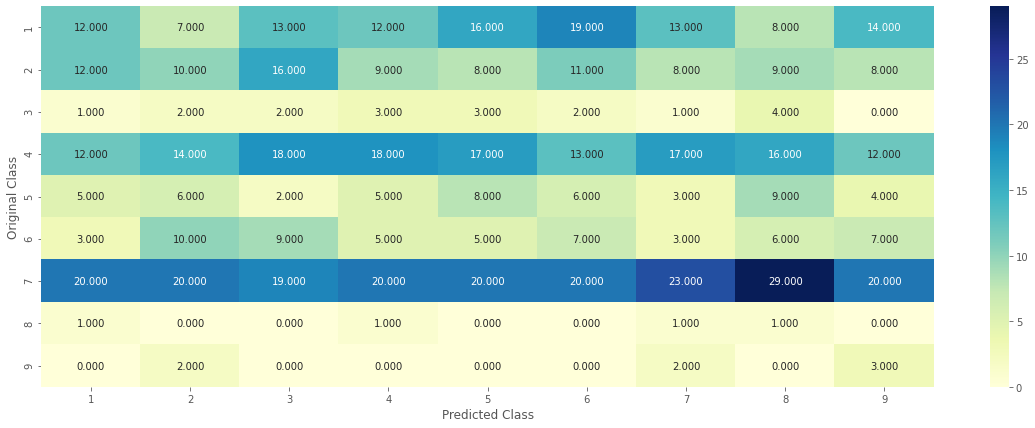

---------------------------------------- Precision matrix (Columm Sum=1) ----------------------------------------


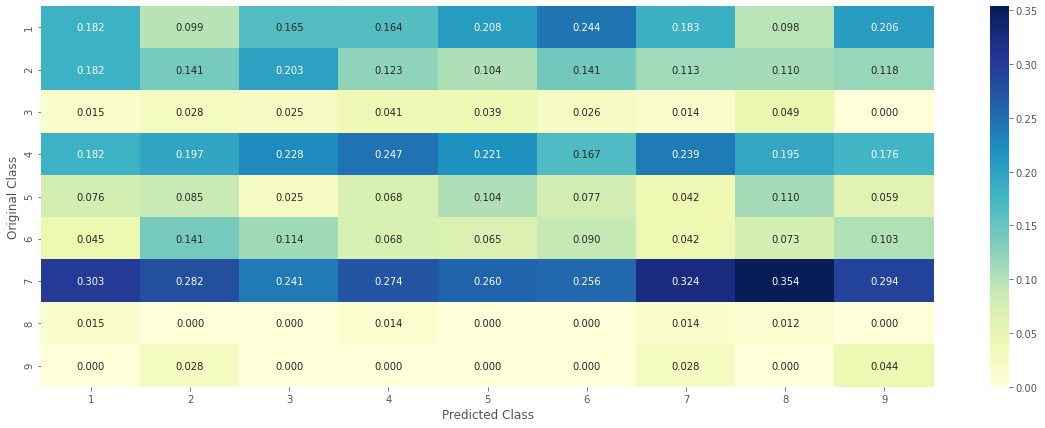

---------------------------------------- Recall matrix (Row sum=1) ----------------------------------------


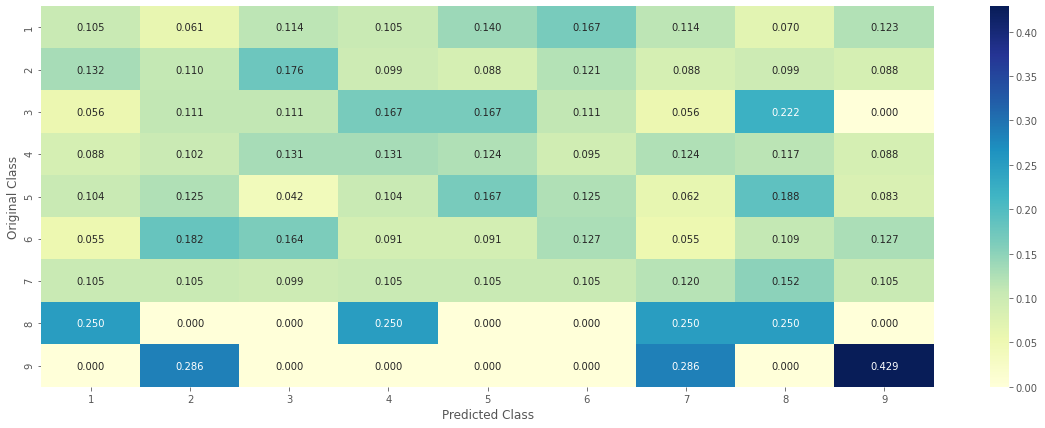

In [12]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

#Step 1: Create a output array which has size same as CV data
cv_predicted_y = np.zeros((cv_data_len,9))

#Step 2: For i in range (0 , Cv_len) we have to create random prob and then sum it up so that it will be 100%
for i in range(cv_data_len):  
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])

# Step 3. Print Log-loss on Random model for Cv-data
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))

# For Test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

#### Log Loss - 
    One of the Biggest dis-advantage of Log-loss is that as it ranges from (0 - Infinity) so if 0 means our model is better but what value our model can be worst bcoz it says to be infinity but we dont actually get zero in such cases So one of the biggest advantage of using Dumb model is that we can now get a threshold that our worst Log- Loss can be upto lets say 2.5 so if we use Actual Ml model our task is to reduce our log loss than 2.5

#### Confusion Matrix - 
    For any Sensible model confusion matrix gives us higher values for diagnol elements but for random model we can see that it has done done that job

####  precision & Recall matrix - 
    Same for Precsion & Recall matrix that it have not done good job bcoz its a random model it works like {if we give any input it will randomly generate class label out of 1-9 everytime} so thats why we call it as Dumb Model


# 6 Univariate Analysis

## 6.1 Univariate Analysis on Gene Feature


<p style="font-size:18px;"> <b>Q1.</b> Gene, What type of feature it is ?</p>
<p style="font-size:16px;"><b>Ans.</b> Gene is a categorical variable </p>
<p style="font-size:18px;"> <b>Q2.</b> How many categories are there and How they are distributed?</p>

In [13]:
unique_genes = train_df["Gene"].value_counts()

In [14]:
unique_genes.shape   #So there are total 240 unique Genes

(230,)

In [15]:
#Print Top 5
unique_genes.head(5)

BRCA1    154
TP53     110
EGFR      82
PTEN      75
BRCA2     72
Name: Gene, dtype: int64

In [16]:
#Print last 5
unique_genes.tail(5)

SRSF2    1
BCL2     1
H3F3A    1
SHOC2    1
MYOD1    1
Name: Gene, dtype: int64

#### Plot CDF for this distrbutions of gene feature

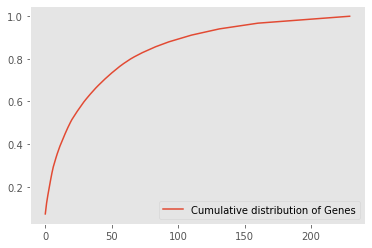

In [17]:
s = sum(unique_genes.values)
h = unique_genes.values/s
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

#### Observation: Out of 240 unique genes only top 50 genes consist more than 70% of data and rest only 30% 

<p style="font-size:18px;"> <b>Q3.</b> How to featurize this Gene feature ?</p>
<ul><li>One hot Encoding</li></ul>

### One hot encoding on Gene Feature using TF-IDF

#### Here i have created a small explaining Tf-idf : https://niharjamdar.medium.com/tf-idf-term-frequency-and-inverse-document-frequency-56a0289d2fb6

In [18]:
gene_vectorizer = TfidfVectorizer(tokenizer=None,stop_words=None,max_df=0.75,max_features=1000,lowercase=False,ngram_range=(1,2))

##### Q. What is max_df = .75
    max_df is used for removing data values that appear too frequently, also known as "corpus-specific stop words". For example: max_df = 0.50 means "It ignores terms that appear in more than 50% of the documents". max_df = 25 means "It ignores terms that appear in more than 25 documents"

In [19]:
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [20]:
gene_vectorizer.get_feature_names()

['ABL1',
 'ACVR1',
 'AGO2',
 'AKT1',
 'AKT2',
 'AKT3',
 'ALK',
 'APC',
 'AR',
 'ARAF',
 'ARID1A',
 'ARID1B',
 'ARID2',
 'ARID5B',
 'ATM',
 'ATRX',
 'AURKA',
 'AXIN1',
 'AXL',
 'B2M',
 'BAP1',
 'BARD1',
 'BCL10',
 'BCL2',
 'BCOR',
 'BRAF',
 'BRCA1',
 'BRCA2',
 'BRD4',
 'BRIP1',
 'BTK',
 'CARD11',
 'CARM1',
 'CASP8',
 'CBL',
 'CCND1',
 'CCND3',
 'CDH1',
 'CDK12',
 'CDK4',
 'CDK8',
 'CDKN1B',
 'CDKN2A',
 'CDKN2B',
 'CEBPA',
 'CIC',
 'CREBBP',
 'CTCF',
 'CTLA4',
 'CTNNB1',
 'DDR2',
 'DICER1',
 'DNMT3A',
 'DNMT3B',
 'DUSP4',
 'EGFR',
 'ELF3',
 'EP300',
 'EPAS1',
 'EPCAM',
 'ERBB2',
 'ERBB3',
 'ERBB4',
 'ERCC2',
 'ERCC3',
 'ERCC4',
 'ERG',
 'ERRFI1',
 'ESR1',
 'ETV1',
 'ETV6',
 'EWSR1',
 'EZH2',
 'FAM58A',
 'FANCA',
 'FANCC',
 'FAT1',
 'FBXW7',
 'FGF19',
 'FGF4',
 'FGFR1',
 'FGFR2',
 'FGFR3',
 'FGFR4',
 'FLT3',
 'FOXA1',
 'FOXL2',
 'FOXO1',
 'FOXP1',
 'GATA3',
 'GNAQ',
 'GNAS',
 'H3F3A',
 'HIST1H1C',
 'HLA',
 'HNF1A',
 'HRAS',
 'IDH1',
 'IDH2',
 'IGF1R',
 'IKBKE',
 'IL7R',
 'INPP4B',
 'JAK1'

In [21]:
print("Dtrain",train_gene_feature_onehotCoding.shape)
print("Dtest",test_gene_feature_onehotCoding.shape)
print("Dtest",cv_gene_feature_onehotCoding.shape)

Dtrain (2124, 229)
Dtest (665, 229)
Dtest (532, 229)


## Q4. How good is this gene feature in predicting y_i?

For values of alpha =  1e-05 The log loss is: 1.1926597307543005
For values of alpha =  0.0001 The log loss is: 1.167356214884773
For values of alpha =  0.001 The log loss is: 1.215849987819669
For values of alpha =  0.01 The log loss is: 1.3237547282035247
For values of alpha =  0.1 The log loss is: 1.413273565757413
For values of alpha =  1 The log loss is: 1.4542222947043775


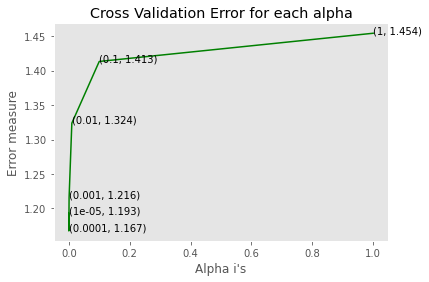

For values of best alpha =  0.0001 The train log loss is: 1.005734541804209
For values of best alpha =  0.0001 The cross validation log loss is: 1.167356214884773
For values of best alpha =  0.0001 The test log loss is: 1.1544314216781624


In [22]:
alpha = [10 ** x for x in range(-5, 1)] #from 0.00001 to 1 
# hyperparam for SGD classifier.
# Here we are using SGD classifier with logistic regression with SGDClassifier(penalty = l2,loss = log)
# So as Logistic reg --> Logistic Loss 
# penalty as l2 regularization which has Lambda corresponding to it so we will tune this hyper-parameter

cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha = i,penalty = "L2",loss = "log",random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    #Note: Bydefault model does not provide output in Probablities so in order to convert those output to probablity we here
    # use CalibratedClassifer with sigmoid calibration by taking input as Output given by ML model and then give output in probabiliy
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()    

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)


predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<p style="font-size:18px;"> <b>Q5.</b> Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?</p>

In [23]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  230  genes in train dataset?
Ans
1. In test data 638 out of 665 : 95.93984962406014
2. In cross validation data 511 out of  532 : 96.05263157894737


<h3>3.2.2 Univariate Analysis on Variation Feature</h3>

<p style="font-size:18px;"> <b>Q1.</b> Variation, What type of feature is it ?</p>
<p style="font-size:16px;"><b>Ans.</b> Variation is a categorical variable </p>
<p style="font-size:18px;"> <b>Q2.</b> How many categories are there?</p>

In [24]:
unique_variations = train_df["Variation"].value_counts()

In [25]:
unique_variations.shape   #So there are total 1935 unique variations

(1941,)

In [26]:
#Print Top 5
unique_variations.head(5)

Truncating_Mutations    54
Amplification           47
Deletion                44
Fusions                 15
Overexpression           4
Name: Variation, dtype: int64

In [27]:
#Print last 5
unique_variations.tail(5)

Y234H                1
E265K                1
CUX1-FGFR1_Fusion    1
S2483N               1
D96N                 1
Name: Variation, dtype: int64

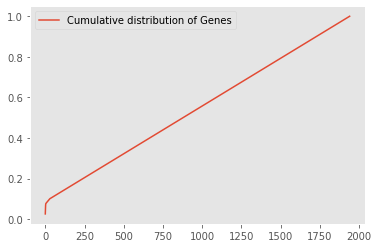

In [28]:
s = sum(unique_variations.values)
h = unique_variations.values/s
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

<p style="font-size:18px;"> <b>Q3.</b> How to featurize this VARIATION feature ?</p>
<ul><li>One hot Encoding</li></ul>

### One hot encoding on Gene Feature using TF-IDF

In [29]:
variation_vectorizer = TfidfVectorizer(tokenizer=None,stop_words=None,max_df=0.75,max_features=1000,lowercase=False,ngram_range=(1,2))

In [30]:
train_variation_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = gene_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = gene_vectorizer.transform(cv_df['Variation'])

### Q4. How good is this gene feature in predicting y_i?

For values of alpha =  1e-05 The log loss is: 1.685328641311384
For values of alpha =  0.0001 The log loss is: 1.6822956343067603
For values of alpha =  0.001 The log loss is: 1.6881216008122766
For values of alpha =  0.01 The log loss is: 1.7010040539334907
For values of alpha =  0.1 The log loss is: 1.706525567734521
For values of alpha =  1 The log loss is: 1.708827017476158


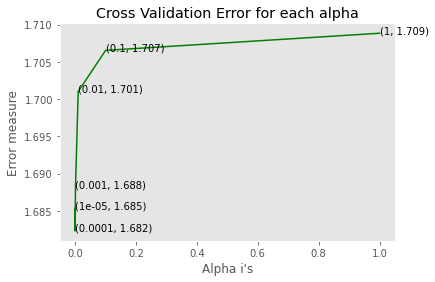

For values of best alpha =  0.0001 The train log loss is: 1.185133844326524
For values of best alpha =  0.0001 The cross validation log loss is: 1.6822956343067603
For values of best alpha =  0.0001 The test log loss is: 1.7152892117851528


In [31]:
alpha = [10 ** x for x in range(-5, 1)] #from 0.00001 to 1 
# hyperparam for SGD classifier.
# Here we are using SGD classifier with logistic regression with SGDClassifier(penalty = l2,loss = log)
# So as Logistic reg --> Logistic Loss 
# penalty as l2 regularization which has Lambda corresponding to it so we will tune this hyper-parameter

cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha = i,penalty = "L2",loss = "log",random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    #Note: Bydefault model does not provide output in Probablities so in order to convert those output to probablity we here
    # use CalibratedClassifer with sigmoid calibration by taking input as Output given by ML model and then give output in probabiliy
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()    

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)


predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

<p style="font-size:18px;"> <b>Q5.</b> Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?</p>

In [32]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_variations.shape[0], " genes in train dataset?")

test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  1941  genes in train dataset?
Ans
1. In test data 77 out of 665 : 11.578947368421053
2. In cross validation data 61 out of  532 : 11.466165413533833


<h2>3.2.3 Univariate Analysis on Text Feature</h2>


<p style="font-size:18px;"> <b>Q1.</b> How many Unique words are there?</p>

In [33]:
train_df['TEXT'].head(3)

2085    argonaute ago proteins mediate silencing nucle...
948     chronic myeloproliferative disorders cmpd clon...
1423    although activating mutations fgfr3 frequent b...
Name: TEXT, dtype: object

In [34]:
train_df['TEXT'] = train_df['TEXT'].astype("str")
test_df['TEXT'] = test_df['TEXT'].astype("str")
cv_df['TEXT'] = cv_df['TEXT'].astype("str")

In [35]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 665 entries, 2309 to 1120
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         665 non-null    int64 
 1   Gene       665 non-null    object
 2   Variation  665 non-null    object
 3   Class      665 non-null    int64 
 4   TEXT       665 non-null    object
dtypes: int64(2), object(3)
memory usage: 31.2+ KB


In [36]:
text_vectorizer = TfidfVectorizer(tokenizer=None,stop_words=None,max_df=0.80,max_features=500,lowercase=False,ngram_range=(1,2))

In [37]:
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
#test_gene_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
#cv_gene_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])

In [38]:
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])

In [39]:
#Before Normalizing
cv_text_feature_onehotCoding

<532x500 sparse matrix of type '<class 'numpy.float64'>'
	with 142419 stored elements in Compressed Sparse Row format>

In [40]:
#normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [41]:
train_text_features= text_vectorizer.get_feature_names()

In [42]:
#After Normalizing
cv_text_feature_onehotCoding

<532x500 sparse matrix of type '<class 'numpy.float64'>'
	with 142419 stored elements in Compressed Sparse Column format>

For values of alpha =  1e-05 The log loss is: 1.1687289723815772
For values of alpha =  0.0001 The log loss is: 1.1850747022389667
For values of alpha =  0.001 The log loss is: 1.4377274718760245
For values of alpha =  0.01 The log loss is: 1.8307118645346179
For values of alpha =  0.1 The log loss is: 1.9258626920949249
For values of alpha =  1 The log loss is: 1.9220736433646919


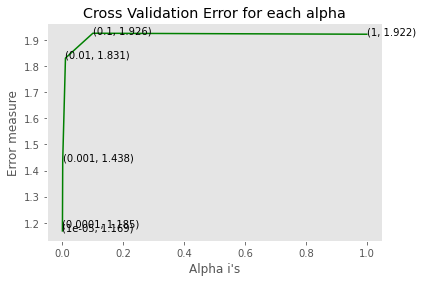

For values of best alpha =  1e-05 The train log loss is: 0.8021200020876431
For values of best alpha =  1e-05 The cross validation log loss is: 1.1687289723815772
For values of best alpha =  1e-05 The test log loss is: 1.020132598127452


In [43]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<p style="font-size:18px;"> <b>Q.</b> Is the Text feature stable across all the data sets (Test, Train, Cross validation)?</p>

In [44]:
def get_intersec_text(df):
    df_text_vec = TfidfVectorizer(tokenizer=None,stop_words=None,max_df=0.80,max_features=500,lowercase=False,ngram_range=(1,2))
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [45]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

92.0 % of word of test data appeared in train data
87.6 % of word of Cross Validation appeared in train data


### Conclusion of Univariate on 3 features

## 7 Use Machine Learning Models

In [46]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    plot_confusion_matrix(test_y, pred_y)

In [47]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

<p style="font-size:24px;text-align:Center"> <b>Stacking the three types of features </b><p>

In [48]:
# merging gene, variance and text features

# Stack using hstack

#eg: a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

## Step 1 horizonal stacking of gene and var to gene_var
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

## Step 2 Horizontal stacking of text and gene_var
train_x_onehotCoding = hstack((train_text_feature_onehotCoding,train_gene_var_onehotCoding)).tocsr()
## .tocsr() = Convert this matrix to Compressed Sparse Row format
## documentation : https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.coo_matrix.tocsr.html
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_text_feature_onehotCoding,test_gene_var_onehotCoding)).tocsr()
test_y = np.array(list(test_df["Class"]))

cv_x_onehotCoding = hstack((cv_text_feature_onehotCoding,cv_gene_var_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df["Class"]))

In [49]:
print("train_x_onehotCoding.shape:",train_x_onehotCoding.shape)
print("test_x_onehotCoding.shape:",test_x_onehotCoding.shape)
print("cv_x_onehotCoding.shape:",cv_x_onehotCoding.shape)

train_x_onehotCoding.shape: (2124, 1729)
test_x_onehotCoding.shape: (665, 1729)
cv_x_onehotCoding.shape: (532, 1729)


<p style="font-size:24px;text-align:Center"> <b>Machine Learning Model 1 Naive Bayes with Hyper parameter tuning </b><p>

<img src="naive.png" width="600" height="300">

for alpha = 1e-05
Log Loss : 1.144177993651966
for alpha = 0.0001
Log Loss : 1.143969737334489
for alpha = 0.001
Log Loss : 1.1428156053976597
for alpha = 0.1
Log Loss : 1.160143198721079
for alpha = 1
Log Loss : 1.2081682925042567
for alpha = 10
Log Loss : 1.3007833838388478
for alpha = 100
Log Loss : 1.317864042764482
for alpha = 1000
Log Loss : 1.3226361000307845


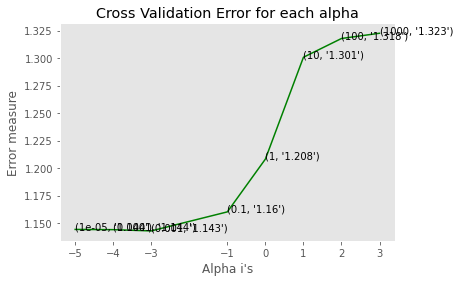

For values of best alpha =  0.001 The train log loss is: 0.7287951525183419
For values of best alpha =  0.001 The cross validation log loss is: 1.1428156053976597
For values of best alpha =  0.001 The test log loss is: 1.1494161324504777


In [50]:
## Naive Bayes classifier are Divided into 3 categories 

# 1. Gaussion naive bayes : continous values in features which uses gausion distribution(i.e higher value at mean but as we go away from mean value get lesser)
# eg: Iris dataset    

# 2. Multinomial naive bayes: When we have discrete data in features [eg: Word count for text classification, where each word has freq]
# eg: works good in text data

# 3. Bernouli naivebayes : When data in features are in binary (0,1)

### Out of these 3 we will use Multinomial naive bayes

                                   
                                ############ Code starts ###########
    
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
## we will use {alpha from Laplace smoothing} as our hyper parameter which basically help us to avoid problem of Zero probablities

cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# np.argmin gives the index of min log-loss error score we got so we will assign to best_alpha
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Log Loss : 1.1428156053976597
---------------------------------------- Confusion matrix ----------------------------------------


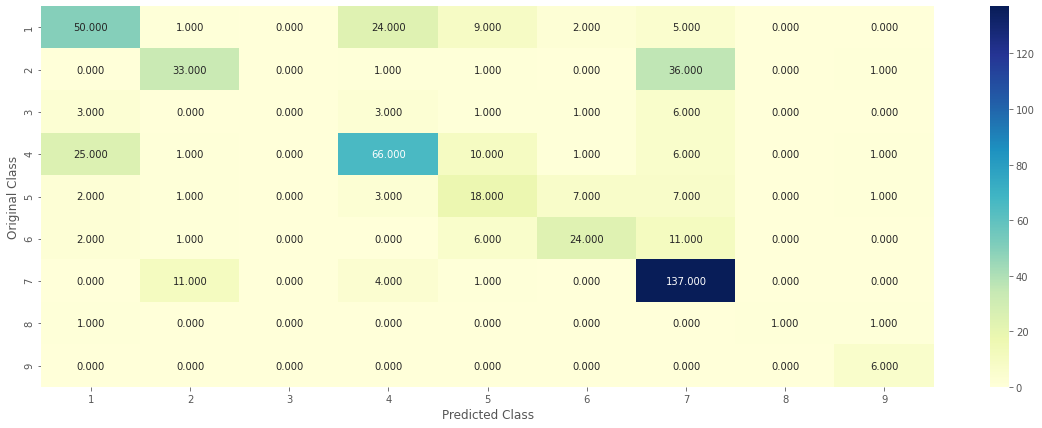

---------------------------------------- Precision matrix (Columm Sum=1) ----------------------------------------


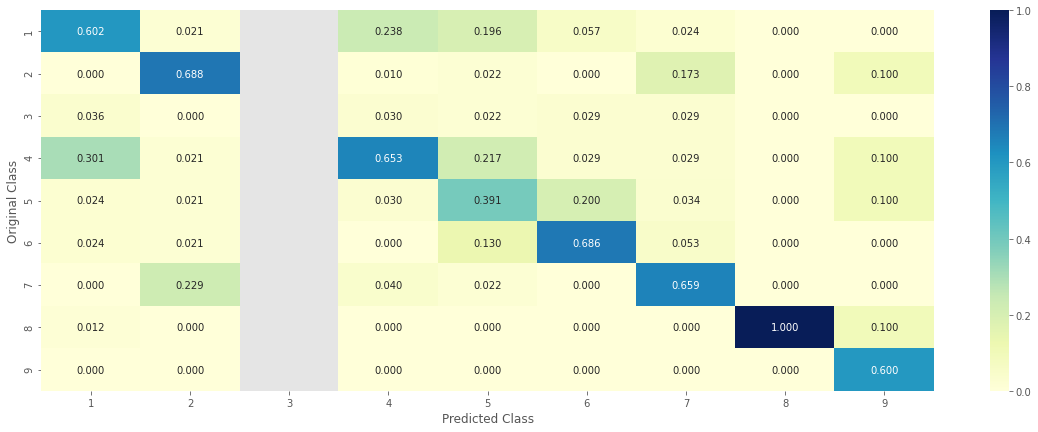

---------------------------------------- Recall matrix (Row sum=1) ----------------------------------------


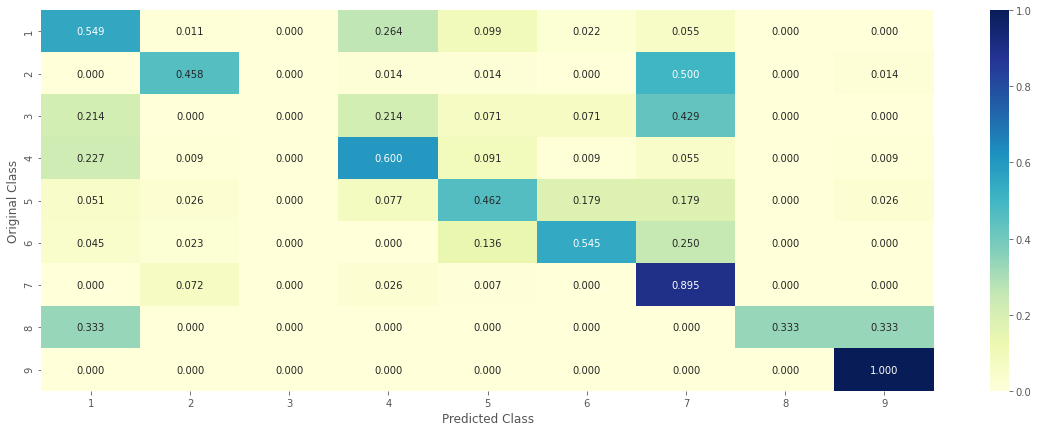

In [51]:
clf = MultinomialNB(alpha=alpha[best_alpha])  ## Taking best alpha 
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
print("Log Loss :",log_loss(cv_y, sig_clf_probs))

plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

### Log-Loss in Naive Bayes with best alpha = 0.001:
        Train   CV    Test
        0.77    1.14  1.14

<p style="font-size:24px;text-align:Center"> <b>Machine Learning Model 2 K-NN with Hyper parameter tuning </b><p>

<img src="knn.png" width="600" height="300">

for k = 3
log-loss: 1.188938022710707
for k = 5
log-loss: 1.1606238511177376
for k = 7
log-loss: 1.1472590785836425
for k = 11
log-loss: 1.1487707823851137
for k = 15
log-loss: 1.163659360003762
for k = 21
log-loss: 1.1953951433819254
for k = 31
log-loss: 1.2224783586056749
for k = 41
log-loss: 1.249749866853089
for k = 51
log-loss: 1.2611510290888224
for k = 91
log-loss: 1.2906707083094027


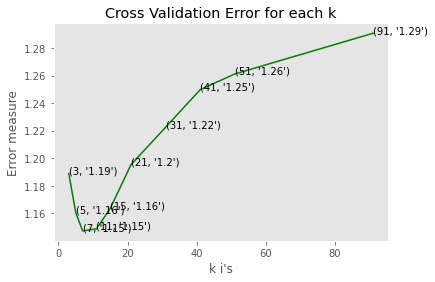

For values of best alpha =  7 The train log loss is: 0.9719115207203977
For values of best alpha =  7 The cross validation log loss is: 1.1472590785836425
For values of best alpha =  7 The test log loss is: 1.148935099905141


In [52]:
k = [3,5,7,11,15,21,31,41,51,91]
# here we use k in k-nn 
cv_log_error_array = []
for i in k:
    print("for k =",i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y,sig_clf_probs,labels = clf.classes_,eps = 1e-15))
    print("log-loss:",log_loss(cv_y,sig_clf_probs))    
    
fig, ax = plt.subplots()
ax.plot(k,cv_log_error_array,c = 'g')
for i , txt in enumerate(np.round(cv_log_error_array,2)):
    ax.annotate((k[i],str(txt)), (k[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each k")
plt.xlabel("k i's")
plt.ylabel("Error measure")
plt.show()


best_k = np.argmin(cv_log_error_array)
# np.argmin gives index number of min log-loss score
clf = KNeighborsClassifier(n_neighbors=k[best_k])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', k[best_k], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', k[best_k], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', k[best_k], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1472590785836425
---------------------------------------- Confusion matrix ----------------------------------------


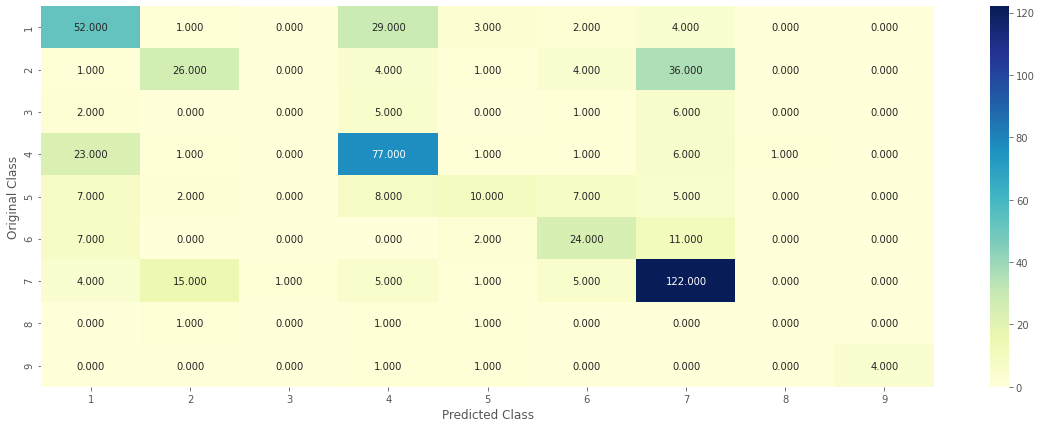

---------------------------------------- Precision matrix (Columm Sum=1) ----------------------------------------


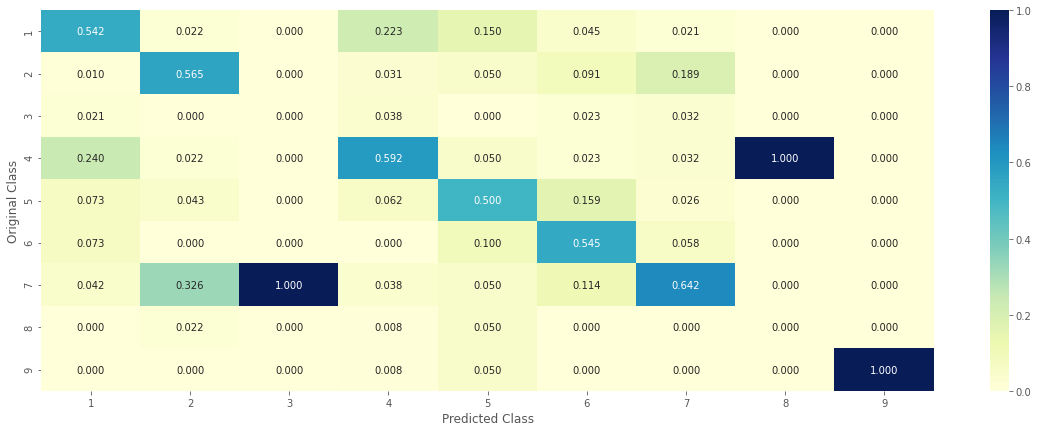

---------------------------------------- Recall matrix (Row sum=1) ----------------------------------------


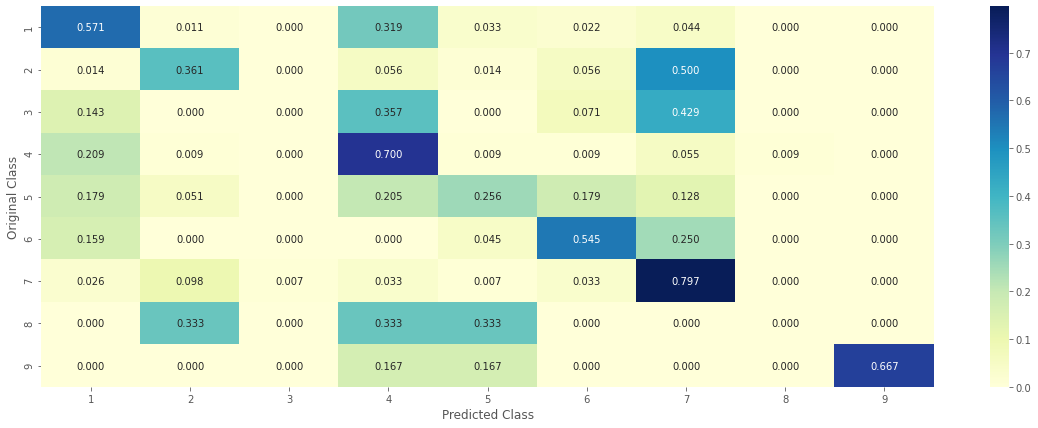

In [53]:
clf = KNeighborsClassifier(n_neighbors= k[best_k])
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

###    Compare log-loss on        
                             K-NN (k = 7)          v/s     Naive Bayes (alpha = 0.001)

                            Train   CV    Test              Train   CV    Test
                            0.97    1.14  1.14              0.77    1.14  1.14               

<p style="font-size:24px;text-align:Center"> <b>Machine Learning Model 3 Logistic Regression (Class Balancing) with Hyper parameter tuning </b><p>

<img src="logistic.png" width="600" height="300">

for alpha: 1e-06
log_loss: 1.153824677167456
for alpha: 1e-05
log_loss: 1.025484490469583
for alpha: 0.0001
log_loss: 0.9871676265671099
for alpha: 0.001
log_loss: 1.0428602074514979
for alpha: 0.01
log_loss: 1.2168828864229937
for alpha: 0.1
log_loss: 1.4237989204195416
for alpha: 1
log_loss: 1.5415221097262801
for alpha: 10
log_loss: 1.5585169950012692
for alpha: 100
log_loss: 1.560618509735786


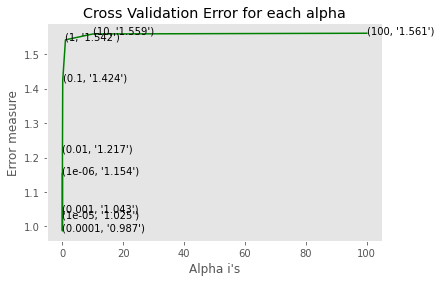

For values of best alpha =  0.0001 The train log loss is: 0.5971209500179653
For values of best alpha =  0.0001 The train log loss is: 0.9871676265671099
For values of best alpha =  0.0001 The train log loss is: 0.9673155293275663


In [60]:
alpha = [10 ** x for x in range(-6,3) ]
# Here alpha is lambda from (regularization technque we will use)
cv_log_error_array = []
for i in alpha:
    print("for alpha:",i)
    clf = SGDClassifier(class_weight = "balanced",alpha = i,penalty = "l2",loss= "log",random_state = 42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf,method = "sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y,sig_clf_probs,labels = clf.classes_,eps = 1e-15))
    print("log_loss:",log_loss(cv_y,sig_clf_probs))
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight = "balanced",alpha = alpha[best_alpha],penalty = "l2",loss = "log",random_state = 42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf,method = "sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ',alpha[best_alpha], "The train log loss is:",log_loss(y_train,predict_y,labels = clf.classes_,eps = 1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ',alpha[best_alpha], "The train log loss is:",log_loss(y_cv,predict_y,labels = clf.classes_,eps = 1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ',alpha[best_alpha], "The train log loss is:",log_loss(y_test,predict_y,labels = clf.classes_,eps = 1e-15))

Log loss : 0.9871676265671099
---------------------------------------- Confusion matrix ----------------------------------------


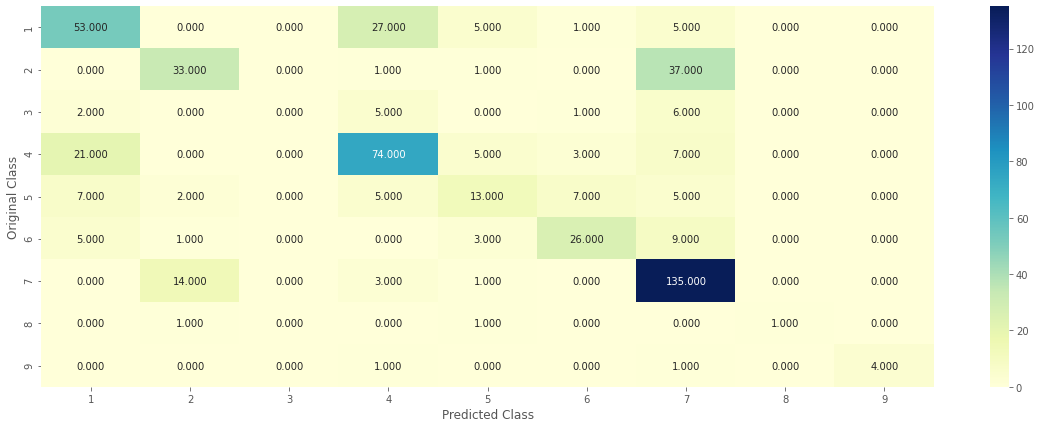

---------------------------------------- Precision matrix (Columm Sum=1) ----------------------------------------


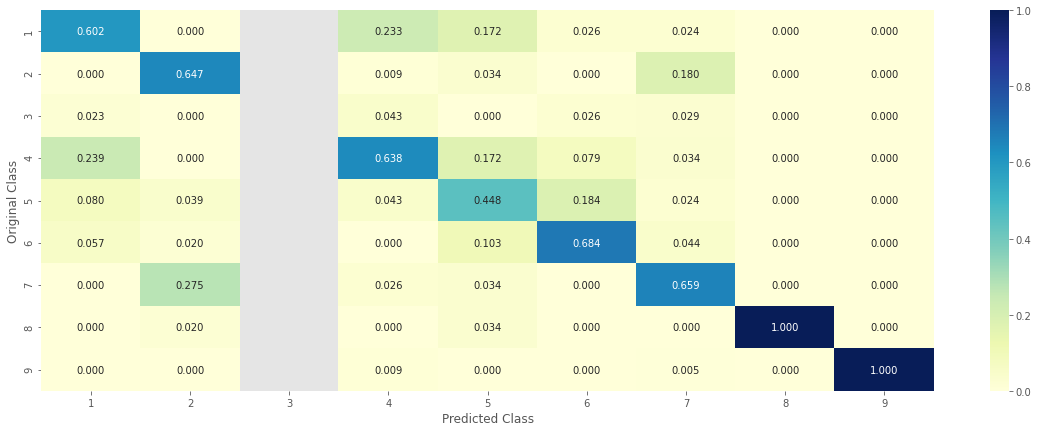

---------------------------------------- Recall matrix (Row sum=1) ----------------------------------------


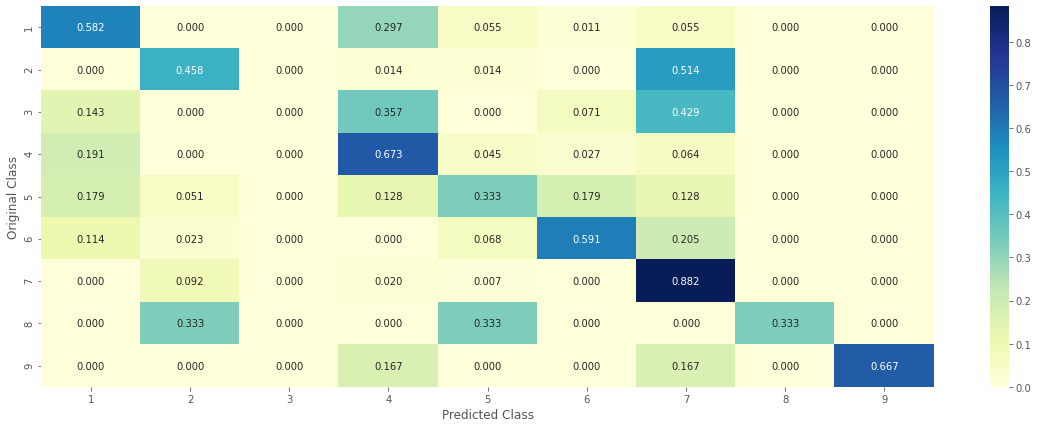

In [61]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

###    Compare log-loss on        
      K-NN (k = 7)          v/s     Naive Bayes (alpha = 0.001)  v/s Logistic with CB (alpha = 0.0001)

      Train   CV    Test              Train   CV    Test              Train   CV    Test
      0.97    1.14  1.14              0.77    1.14  1.14               0.59   0.98  0.96

<p style="font-size:24px;text-align:Center"> <b>Machine Learning Model 4 Logistic Regression ( Without Class Balancing) with Hyper parameter tuning </b><p>

<img src="logistic.png" width="600" height="300">

for alpha: 1e-06
log_loss: 1.213714734313854
for alpha: 1e-05
log_loss: 1.0409506323395927
for alpha: 0.0001
log_loss: 0.9936136933253112
for alpha: 0.001
log_loss: 1.068213994897803
for alpha: 0.01
log_loss: 1.2495128534665634
for alpha: 0.1
log_loss: 1.5385005055244514
for alpha: 1
log_loss: 1.6506088970161858
for alpha: 10
log_loss: 1.664529150677923
for alpha: 100
log_loss: 1.666408139863566


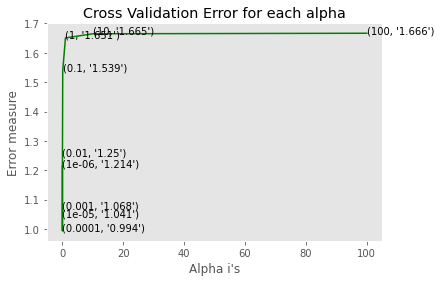

For values of best alpha =  0.0001 The train log loss is: 0.5876380505694365
For values of best alpha =  0.0001 The train log loss is: 0.9936136933253112
For values of best alpha =  0.0001 The train log loss is: 0.979385821331225


In [62]:
alpha = [10 ** x for x in range(-6,3) ]
# Here alpha is lambda from (regularization technque we will use)
cv_log_error_array = []
for i in alpha:
    print("for alpha:",i)
    clf = SGDClassifier(alpha = i,penalty = "l2",loss= "log",random_state = 42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf,method = "sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y,sig_clf_probs,labels = clf.classes_,eps = 1e-15))
    print("log_loss:",log_loss(cv_y,sig_clf_probs))
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha = alpha[best_alpha],penalty = "l2",loss = "log",random_state = 42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf,method = "sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ',alpha[best_alpha], "The train log loss is:",log_loss(y_train,predict_y,labels = clf.classes_,eps = 1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ',alpha[best_alpha], "The train log loss is:",log_loss(y_cv,predict_y,labels = clf.classes_,eps = 1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ',alpha[best_alpha], "The train log loss is:",log_loss(y_test,predict_y,labels = clf.classes_,eps = 1e-15))

Log loss : 0.9936136933253112
---------------------------------------- Confusion matrix ----------------------------------------


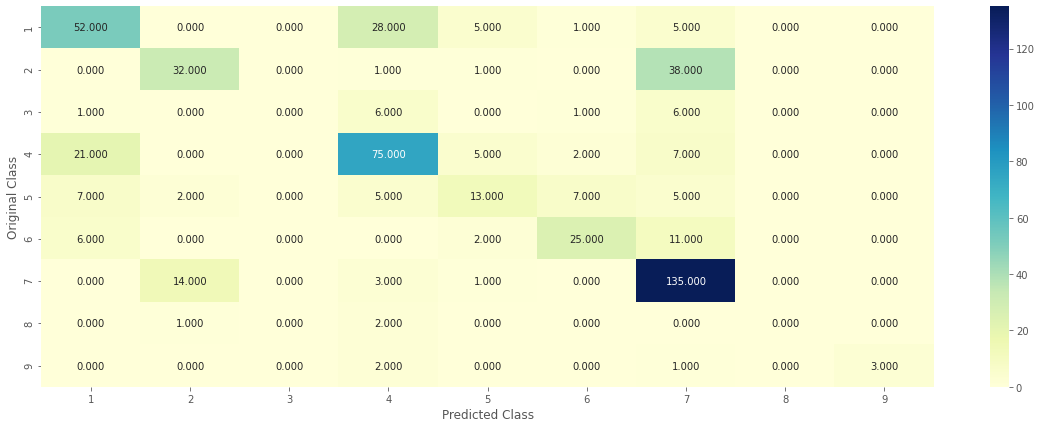

---------------------------------------- Precision matrix (Columm Sum=1) ----------------------------------------


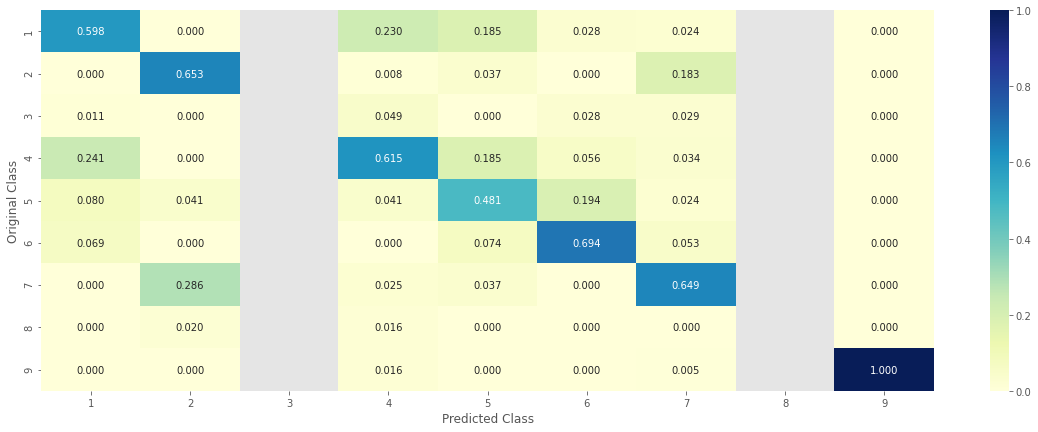

---------------------------------------- Recall matrix (Row sum=1) ----------------------------------------


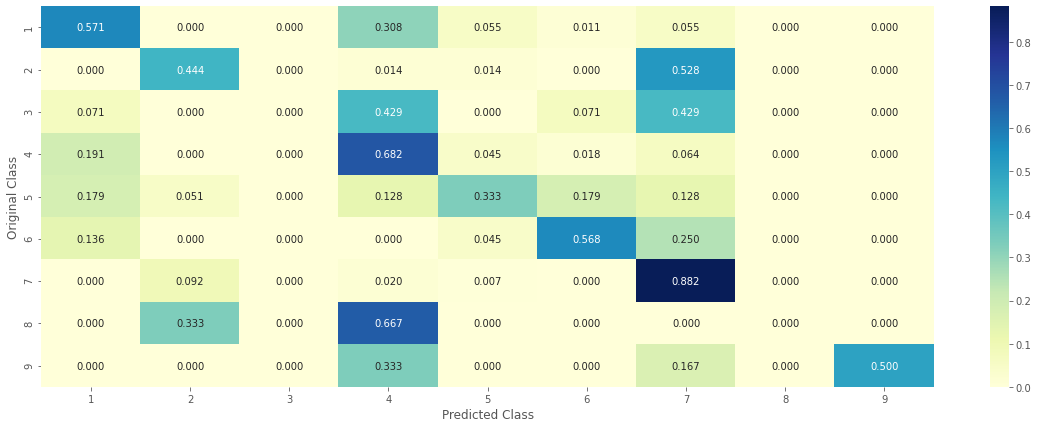

In [63]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

###    Compare log-loss on
    Parameters        KNN  Naive Bayes Logistic Reg (with CB) Logistic Reg(without CB)
    
    best_alpha         7      0.001        0.0001                0.0001
    Train log loss   0.97     0.77         0.59                  0.58
    Test log loss    1.14     1.14         0.98                  0.99
    CV log loss      1.14     1.44         0.96                  0.99


<p style="font-size:24px;text-align:Center"> <b>Machine Learning Model 5 Linear SVM with Hyper parameter tuning </b><p>

<img src="support.jpg" width="500" height="250">

for C = 1e-05
Log Loss : 1.1525830763333023
for C = 0.0001
Log Loss : 1.1462367336852657
for C = 0.001
Log Loss : 1.1774169011417173
for C = 0.01
Log Loss : 1.3164250136764883
for C = 0.1
Log Loss : 1.5472734491543656
for C = 1
Log Loss : 1.5612617651369516
for C = 10
Log Loss : 1.5612672962635397
for C = 100
Log Loss : 1.561267400037315


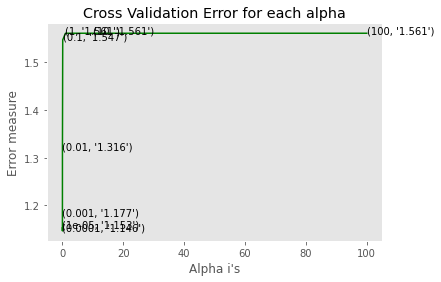

For values of best alpha =  0.0001 The train log loss is: 0.6236006764211139
For values of best alpha =  0.0001 The cross validation log loss is: 1.1462367336852657
For values of best alpha =  0.0001 The test log loss is: 1.1181466855269955


In [64]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.1462367336852657
---------------------------------------- Confusion matrix ----------------------------------------


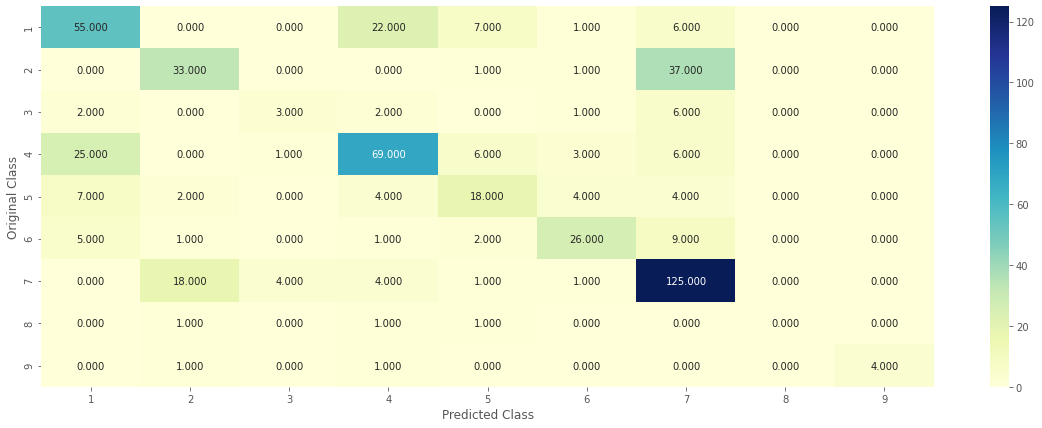

---------------------------------------- Precision matrix (Columm Sum=1) ----------------------------------------


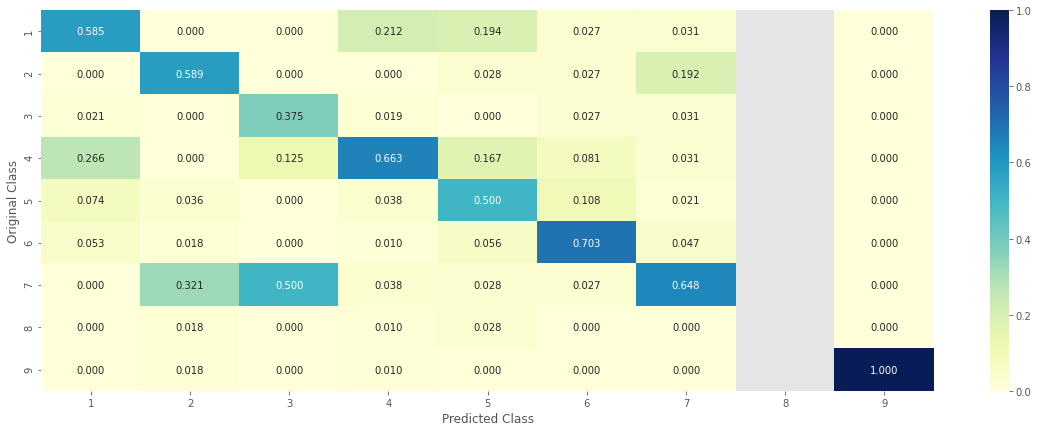

---------------------------------------- Recall matrix (Row sum=1) ----------------------------------------


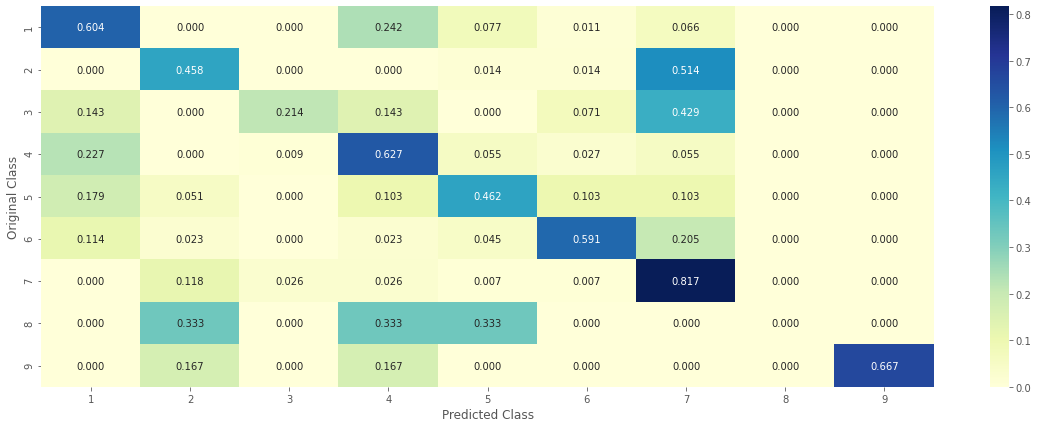

In [65]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

###    Compare log-loss on
    Parameters        KNN || Naive Bayes || Logistic Reg (with CB) || Logistic Reg(without CB) || Linear SVM
    
    best_alpha         7       0.001           0.0001                    0.0001                    0.0001
    Train log loss   0.97      0.77            0.59                      0.58                      0.62
    Test log loss    1.14      1.14            0.98                      0.99                      1.14
    CV log loss      1.14      1.44            0.96                      0.99                      1.18

### Conclusion: So we can see that Logistic Regression (with & without ) Class Balancing works better by providing less log-loss